In [1]:
from optparse import OptionParser
import json
import os
import pickle
import random
import re
import pandas as pd
import pysam
import h5py
import numpy as np

In [2]:
import tensorflow as tf
from basenji import seqnn, stream

2024-03-01 10:12:48.822619: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 10:12:48.822743: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 10:12:48.824343: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-01 10:12:48.835205: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-01 10:12:50.151267: W tensorflow/compiler/tf2

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' ### run on CPU

In [4]:
print(tf.config.list_physical_devices('GPU'))

[]


In [5]:
from akita_utils.h5_utils import (initialize_stat_output_h5, write_stat_metrics_to_h5)
from akita_utils.seq_gens import (symmertic_insertion_seqs_gen)
from akita_utils.dna_utils import dna_1hot

In [6]:
from akita_utils.tsv_gen_utils import (
    add_orientation,
    add_background,
    add_const_flank_and_diff_spacer,
)

In [7]:
# arguments 

genome_fasta = "/project/fudenber_735/genomes/mm10/mm10.fa" 
out_dir = "./OUT"
stats = "SCD,OFF-16,OFF-64,OFF-128"
# stats = "SCD"
batch_size=8 
head_index = 1
model_index = 1
shifts = "0"
rc = False
background_file = f"/project/fudenber_735/akitaX1_analyses_data/background_generation/background_generation/background_sequences_model_{model_index}.fa"

In [8]:
# CTCT_table = "/home1/smaruj/akitaX1-analyses/experiments/virtual_insertion_experiment/input_data/CTCFs_jaspar_filtered_mm10_single_insertion_30flanks.tsv"
CTCT_table = "./top10_insSCD.tsv"

In [9]:
shifts = [int(shift) for shift in shifts.split(",")]
stats = stats.split(",")

In [10]:
models_dir="/project/fudenber_735/tensorflow_models/akita/v2/models"

In [11]:
params_file = models_dir + f"/f{model_index}c0" + "/train" + "/params.json"

In [12]:
params_file

'/project/fudenber_735/tensorflow_models/akita/v2/models/f1c0/train/params.json'

In [13]:
model_file = models_dir + f"/f{model_index}c0" + "/train" + f"/model{head_index}_best.h5"

In [14]:
model_file

'/project/fudenber_735/tensorflow_models/akita/v2/models/f1c0/train/model1_best.h5'

In [15]:
# read model parameters
with open(params_file) as params_open:
    params = json.load(params_open)
params_train = params["train"]
params_model = params["model"]

if batch_size is None:
    batch_size = params_train["batch_size"]
else:
    batch_size = batch_size

In [16]:
# load model
seqnn_model = seqnn.SeqNN(params_model)
seqnn_model.restore(model_file, head_i=head_index)
seqnn_model.build_ensemble(rc, shifts)
seq_length = int(params_model["seq_length"])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence (InputLayer)       [(None, 1310720, 4)]         0         []                            
                                                                                                  
 stochastic_reverse_complem  ((None, 1310720, 4),         0         ['sequence[0][0]']            
 ent (StochasticReverseComp   ())                                                                 
 lement)                                                                                          
                                                                                                  
 stochastic_shift (Stochast  (None, 1310720, 4)           0         ['stochastic_reverse_complemen
 icShift)                                                           t[0][0]']               

In [17]:
seq_length

1310720

In [18]:
# open genome FASTA
genome_open = pysam.Fastafile(genome_fasta)

In [19]:
seq_coords_df = pd.read_csv(CTCT_table, sep="\t")[:3].reset_index(drop=True)

In [20]:
seq_coords_df["seq_index"] = [i for i in range(len(seq_coords_df))]

In [21]:
flank_length = 30
orient_list = ["<<<>>>", "<<<<<<"]
background_indices_list = [x for x in range(10)]
spacing_list=[60]

In [22]:
# adding orientation
seq_coords_df = add_orientation(
    seq_coords_df,
    orientation_strings=orient_list,
    all_permutations=False,
)

# adding background index
seq_coords_df = add_background(
    seq_coords_df, 
    background_indices_list
    )

In [23]:
seq_coords_df = add_const_flank_and_diff_spacer(
        seq_coords_df, 
        flank_length, 
        spacing_list
        )

In [24]:
background_seqs = []
    
with open(background_file, "r") as f:
    for line in f.readlines():
        if ">" in line:
            continue
        background_seqs.append(dna_1hot(line.strip()))

num_insert_backgrounds = seq_coords_df["background_index"].max()

if len(background_seqs) < num_insert_backgrounds:
    raise ValueError(
        "must provide a background file with at least as many"
        + "backgrounds as those specified in the insert seq_coords tsv."
        + "\nThe provided background file has {len(background_seqs)} sequences."
    )

In [26]:
# initialize output
# stats_out = initialize_stat_output_h5(out_dir, model_file, stats, seq_coords_df)

In [27]:
#################################################################
# predictions for references
backgrounds_predictions = seqnn_model.predict(np.array(background_seqs), batch_size=batch_size)

2/2 [==============================] - 8s 2s/step


In [28]:
preds_stream = stream.PredStreamGen(
        seqnn_model,
        symmertic_insertion_seqs_gen(seq_coords_df, background_seqs, genome_open),
        batch_size,
    )

In [29]:
from akita_utils.utils import ut_dense

In [30]:

def slide_diagonal_insulation(target_map, window=10):
    """
    Calculate insulation by sliding a window along the diagonal of the target map.

    Parameters
    ------------
    target_map : numpy array
        Array with contact change maps predicted by Akita, usually of a size (512 x 512)
    window : int
        Size of the sliding window.

    Returns
    ---------
    scores : list
        List of ISN-window scores for each position along the diagonal.
    """

    map_size = target_map.shape[0]
    scores = np.empty((map_size,))
    scores[:] = np.nan
    
    for mid in range(window, (map_size - window)):
        lo = max(0, mid+1-window)
        hi = min(map_size, mid + window)
        score = np.nanmean(target_map[lo:(mid+1), mid:hi])
        scores[mid] = score

    return scores

In [31]:
def extract_window_from_vector(vector, window=10, width=3):
    """
    Extract a window of size 3*window centered around the center of the vector.

    Parameters
    ------------
    vector : list or numpy array
        Input vector.
    window : int, optional
        Size of the window. Default is 16.

    Returns
    ---------
    window_vector : list or numpy array
        Extracted window of size 3*window.
    """
    center_index = len(vector) // 2
    start_index = max(center_index - width*window, 0)
    end_index = min(center_index + width*window, len(vector))
    window_vector = vector[start_index:end_index]
    return window_vector

In [32]:
def min_insulation_offset_from_center(target_map, window=10, crop_around_center=True, crop_width=3):
    """
    Calculate the offset from the center position for the position along the diagonal
    with the minimum insulation score for a sliding window along the diagonal.

    Parameters
    ------------
    target_map : numpy array
        Array with contact change maps predicted by Akita, usually of a size (512 x 512).
    window : int, optional
        Size of the sliding window for insulation calculation. Default is 10.

    Returns
    ---------
    offset_from_center : int
        Offset from the center position based on the position with the minimum insulation score.
    """
    map_size = target_map.shape[0]
    center_position = map_size // 2
    bin_shift = 0
    
    insulation_scores = slide_diagonal_insulation(target_map, window)
    
    if crop_around_center:
        bin_shift = max(center_position - crop_width*window, 0)
        insulation_scores = extract_window_from_vector(insulation_scores, window=window, width=3)
    
    min_score = np.nanmin(insulation_scores)  

    # Find indices with min_score
    indices_tuple = np.where(insulation_scores == min_score)
    indices_list = list(indices_tuple[0])
    
    # in case there are more than one index with min_score
    # Calculate midpoint of the array
    midpoint = len(insulation_scores) // 2
    
    # Find index closest to the midpoint among indices with the same score
    closest_index = None
    min_difference = float('inf')
    for index in indices_list:
        difference = abs(index - midpoint)
        if difference < min_difference:
            closest_index = index
            min_difference = difference

    closest_index = closest_index + bin_shift
    offset_from_center = closest_index - center_position
    return offset_from_center

In [33]:
def calculate_offset_INS(map_matrix, window=10, crop_around_center=True, crop_width=3):
    """
    Calculate insulation in a window-size diamond around the central pixel
    for a set of num_targets contact difference maps.

    Parameters
    ------------
    map_matrix : numpy array
        Array with contact change maps predicted by Akita, usually of a size (512 x 512 x num_targets)
    window : int
        Size of a diamond taken into account in a metric calculation.

    Returns
    ---------
    scores : num_targets-long vector with ISN-window offset
    """

    num_targets = map_matrix.shape[-1]
    map_size = map_matrix.shape[0]
    scores = np.zeros((num_targets,))
    for target_index in range(num_targets):
        offset_from_center = min_insulation_offset_from_center(map_matrix[:, :, target_index], 
                                                               window=window, 
                                                               crop_around_center=crop_around_center, 
                                                               crop_width=crop_width)
        scores[target_index] = offset_from_center
    return scores

In [34]:
import matplotlib.pyplot as plt

In [93]:
def plot_insulation_scores(insulation_scores_ins16, insulation_scores_ins64, insulation_scores_ins128, window_to_plot=70):
    """
    Plot insulation scores against positions along the diagonal.

    Parameters
    ------------
    insulation_scores : list
        List of insulation scores.

    Returns
    ---------
    None
    """
    midpoint = len(insulation_scores_ins16) // 2
    positions_ins16 = [i for i in range(2*window_to_plot)]
    
    plt.figure(figsize=(10, 6))
    plt.plot(positions_ins16, insulation_scores_ins16[midpoint-window_to_plot : midpoint+window_to_plot], marker='o', linestyle='-', c="blue", label="INS-16")
    plt.plot(positions_ins16, insulation_scores_ins64[midpoint-window_to_plot : midpoint+window_to_plot], marker='o', linestyle='-', c="red", label="INS-64")
    plt.plot(positions_ins16, insulation_scores_ins128[midpoint-window_to_plot : midpoint+window_to_plot], marker='o', linestyle='-', c="green", label="INS-128")
    
    plt.xlabel('Mid position along diagonal')
    plt.ylabel('Insulation score')
    # plt.title('Insulation scores along diagonal')

    # Custom x-ticks
    tick_positions = range(0, 2*window_to_plot+10, 10)  # Positions for ticks every 10 units
    tick_labels = [str(i + midpoint - window_to_plot) for i in tick_positions]  # Adjusted labels starting from midpoint-window_to_plot
    
    plt.xticks(tick_positions, tick_labels)  # Apply custom ticks and labels
    
    plt.legend()
    plt.grid(True)
    plt.show()

In [36]:
num_experiments = len(seq_coords_df)

In [37]:
stats

['SCD', 'OFF-16', 'OFF-64', 'OFF-128']

In [38]:
from akita_utils.stats_utils import plot_map

In [39]:
from akita_utils.utils import ut_dense

In [ ]:
# from akita_utils.stats_utils import calculate_SCD
# from akita_utils.stats_utils import calculate_offset_INS, min_insulation_position_and_offset, slide_diagonal_insulation

In [40]:
summary_matrix = np.zeros((3, 2, 6, 10, 130305))

In [96]:
# seq_coords_df

In [41]:
for exp_index in range(num_experiments):
    
    print(f"experiment {exp_index}")

    bg_index = seq_coords_df.iloc[exp_index].background_index
    orient = seq_coords_df.iloc[exp_index].orientation    
    seq_index = seq_coords_df.iloc[exp_index].seq_index
    
    if orient == "<<<>>>":
        orient_index = 0
    if orient == "<<<<<<":
        orient_index = 1 
    
    prediction_matrix = preds_stream[exp_index]

    for target_index in range(6):
        summary_matrix[seq_index, orient_index, target_index, bg_index] = prediction_matrix[:,target_index]


experiment 0
4/4 [==============================] - 24s 6s/step
experiment 1
experiment 2
experiment 3
experiment 4
experiment 5
experiment 6
experiment 7
experiment 8
experiment 9
experiment 10
experiment 11
experiment 12
experiment 13
experiment 14
experiment 15
experiment 16
experiment 17
experiment 18
experiment 19
experiment 20
experiment 21
experiment 22
experiment 23
experiment 24
experiment 25
experiment 26
experiment 27
experiment 28
experiment 29
experiment 30
experiment 31
experiment 32
4/4 [==============================] - 20s 5s/step
experiment 33
experiment 34
experiment 35
experiment 36
experiment 37
experiment 38
experiment 39
experiment 40
experiment 41
experiment 42
experiment 43
experiment 44
experiment 45
experiment 46
experiment 47
experiment 48
experiment 49
experiment 50
experiment 51
experiment 52
experiment 53
experiment 54
experiment 55
experiment 56
experiment 57
experiment 58
experiment 59


In [42]:
summary_matrix.shape

(3, 2, 6, 10, 130305)

In [43]:
# averaging over targets
ave_summary_matrix = summary_matrix.mean(axis=(2,3))

In [49]:
summary_matrix.shape

(3, 2, 6, 10, 130305)

In [48]:
target_index = 2
bg_index = 3

seq_index:  0
Orientation: <<<>>>


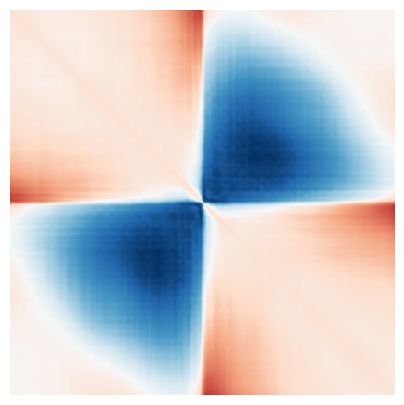

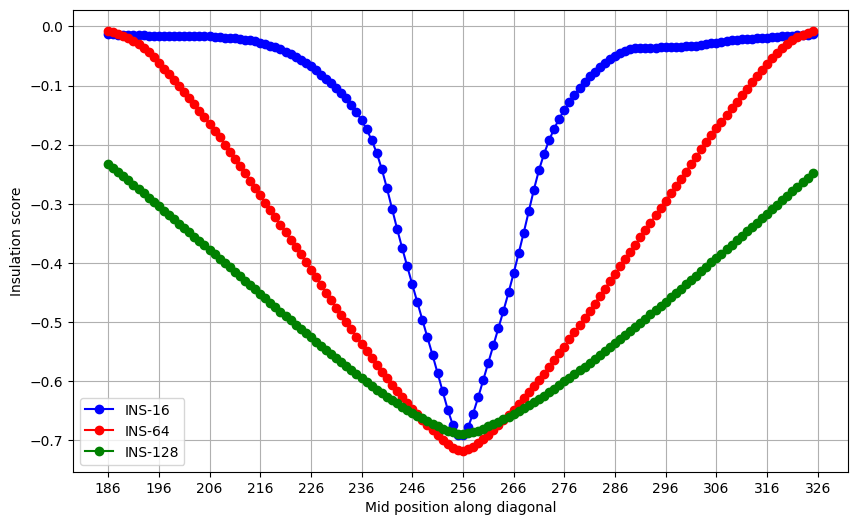

Orientation: <<<<<<


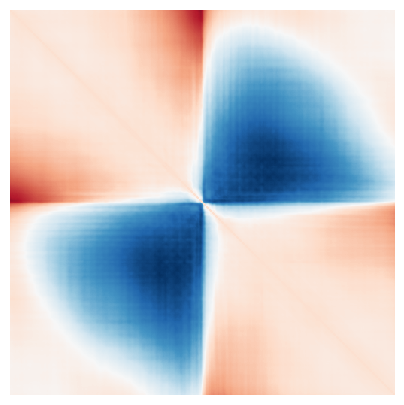

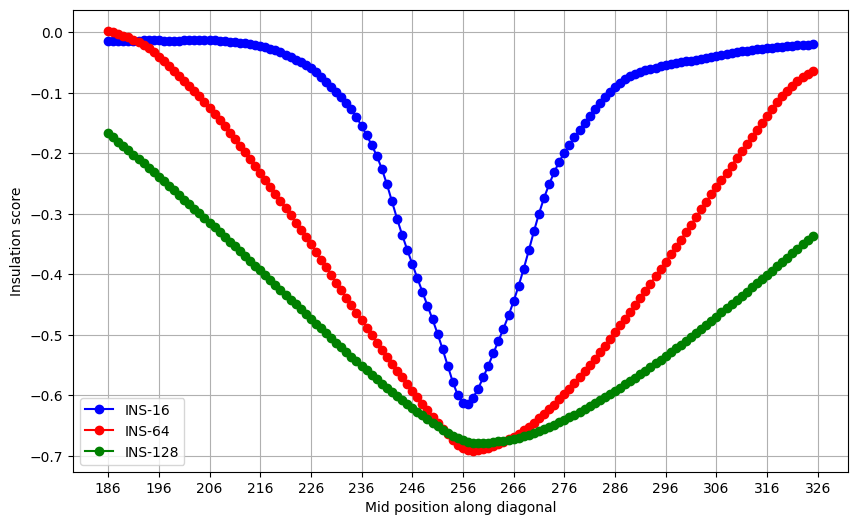

seq_index:  1
Orientation: <<<>>>


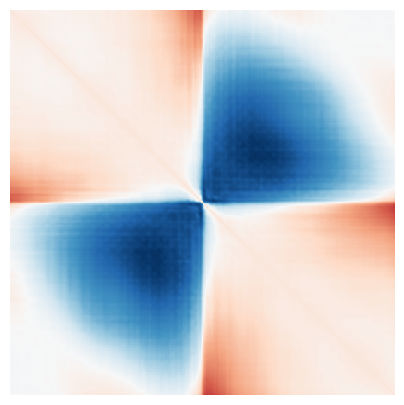

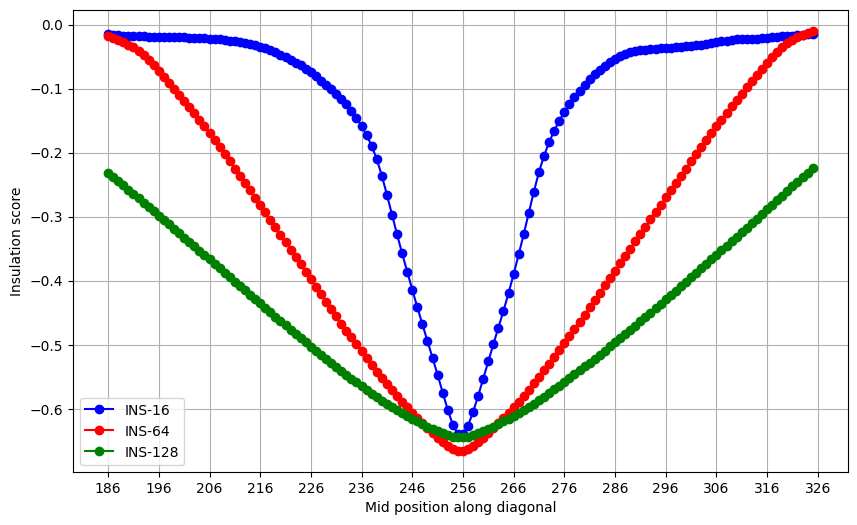

Orientation: <<<<<<


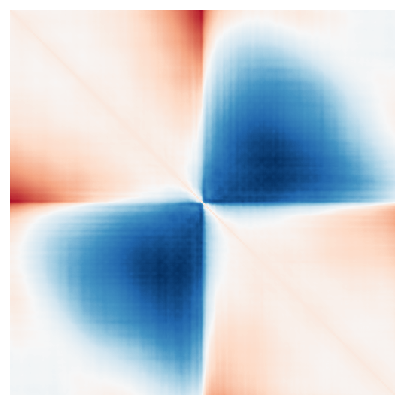

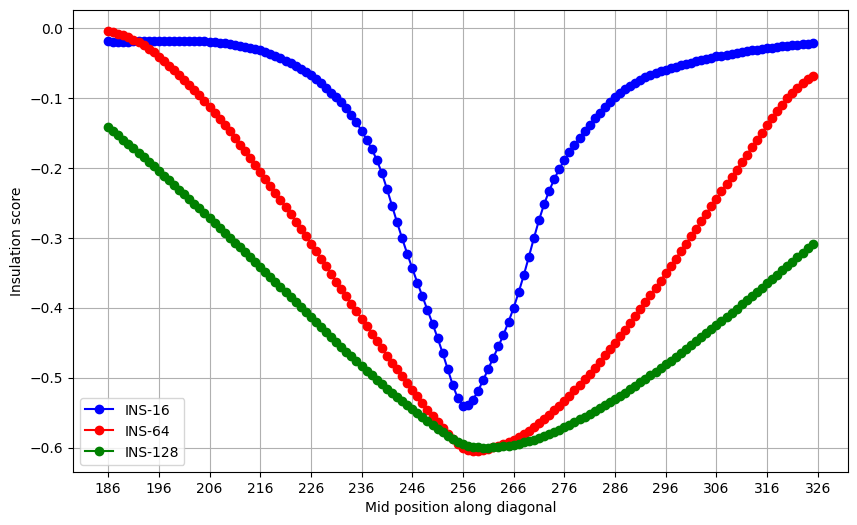

seq_index:  2
Orientation: <<<>>>


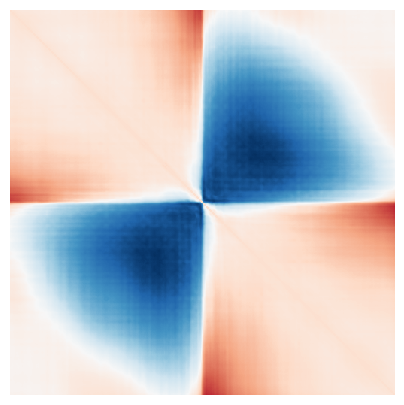

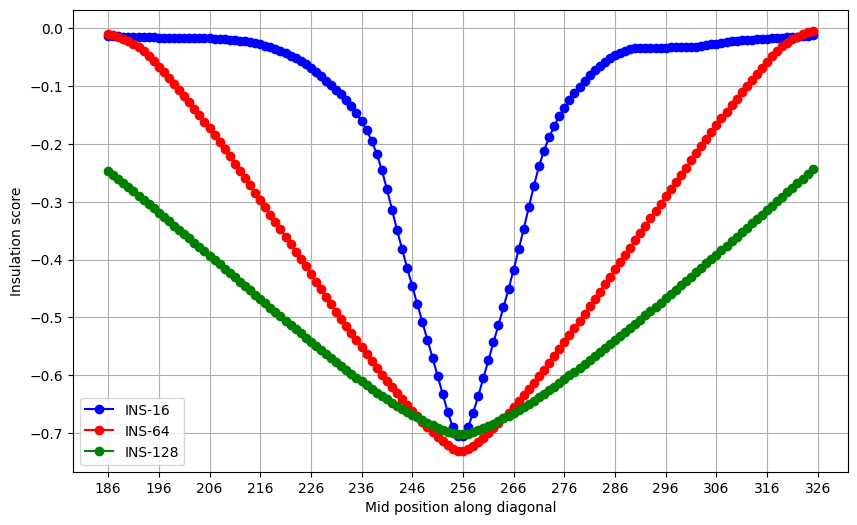

Orientation: <<<<<<


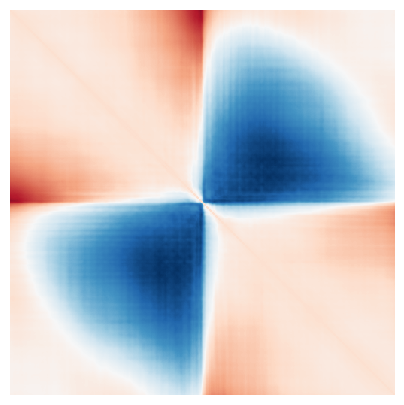

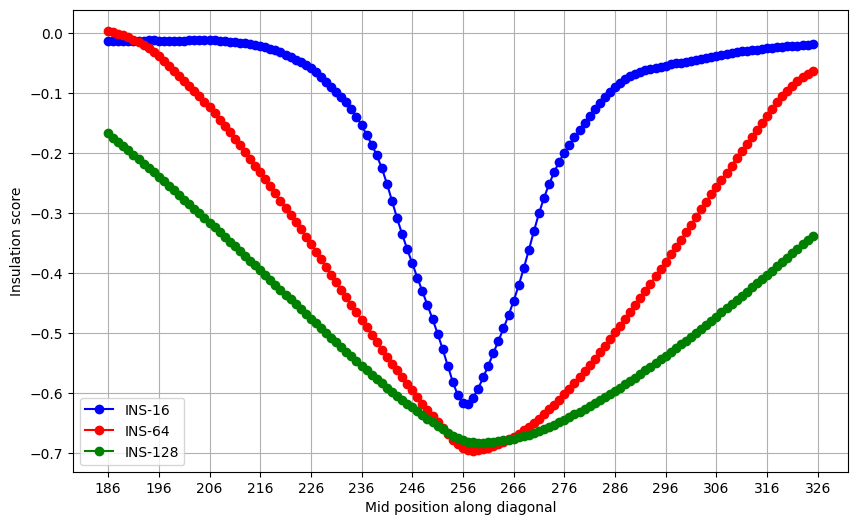

In [94]:
for seq_index in range(summary_matrix.shape[0]):
    print("seq_index: ", seq_index)
    for orient_index in range(summary_matrix.shape[1]):
        if orient_index == 0:
            print("Orientation: <<<>>>")
        else:
            print("Orientation: <<<<<<")
        
        # alt_maps = ut_dense(np.expand_dims(summary_matrix[seq_index, orient_index, target_index, bg_index], axis=1))
        alt_maps = ut_dense(np.expand_dims(ave_summary_matrix[seq_index, orient_index], axis=1))
        plot_map(alt_maps[:,:, 0], vmin=np.min(alt_maps))

        OFF16 = slide_diagonal_insulation(alt_maps, window=16)
        OFF64 = slide_diagonal_insulation(alt_maps, window=64)
        OFF128 = slide_diagonal_insulation(alt_maps, window=128)
        midpoint = len(OFF128) // 2
        window_to_plot = 70
        start = midpoint-window_to_plot
        end = midpoint+window_to_plot
        plot_insulation_scores(OFF16, OFF64, OFF128)

In [ ]:
for key in stats_out:
    print(key)

In [ ]:
stats_out["SCD_h1_m1"][:]

In [ ]:
stats_out["OFF-16_h1_m1"][:]

In [ ]:
stats_out["OFF-64_h1_m1"][:]

In [ ]:
stats_out["OFF-128_h1_m1"][:]

In [ ]:
genome_open.close()
stats_out.close()